In [49]:
import torch
from torch import nn
import torch.nn.functional as F
import pytorch_lightning as pl
import numpy as np
import cv2
from torchvision import transforms
from sklearn.metrics import accuracy_score


In [ ]:
from src.dataset import ImageDataModule, PyradiomicsDataModule
from src.baseline import BaselineClf

In [50]:
class SIFTclassifier(pl.LightningModule):
    def __init__(self, lr = 0.01):
        super().__init__()
        self.lr = lr
        self.sift = cv2.SIFT_create()

    def forward(self, x):
        kp, desc = self.sift.detectAndCompute(x, None)
        features = desc[0].reshape(16, 8)
        print(features)
        return x

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

    def training_step(self, batch, batch_idx):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch 
        out = self(images)                    
        loss = F.cross_entropy(out, labels)   
        _, preds = torch.max(out, dim=1)
        acc = accuracy_score(labels.cpu(), preds.cpu())
        print("Accuracy: ", acc)          
        return {'val_loss': loss, 'val_acc': acc}

    def test_step(self, batch, batch_idx):
        print("test")
        images, labels = batch 
        out = self(images)                    
        loss = F.cross_entropy(out, labels)   
        _, preds = torch.max(out, dim=1)
        acc = accuracy_score(labels.cpu(), preds.cpu())          
        return {'val_loss': loss, 'val_acc': acc}

In [36]:
sift = cv2.SIFT_create()

def show_rgb_img(img):
    return plt.imshow(cv2.cvtColor(img, cv2.CV_32S))

def show_sift_features(img, kp):
    return plt.imshow(cv2.drawKeypoints(img, kp, img.copy()))

def explain_keypoint(kp):
    print ('angle\n', kp.angle)
    print ('\nclass_id\n', kp.class_id)
    print ('\noctave (image scale where feature is strongest)\n', kp.octave)
    print ('\npt (x,y)\n', kp.pt)
    print ('\nresponse\n', kp.response)
    print ('\nsize\n', kp.size)

In [22]:
img1 = cv2.imread("../data/images/no/1 no.jpeg")
img2 = cv2.imread("../data/images/no/2 no.jpeg")


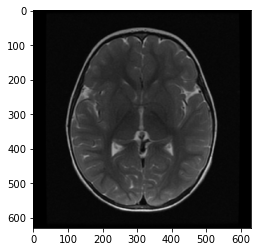

In [23]:
show_rgb_img(img2)


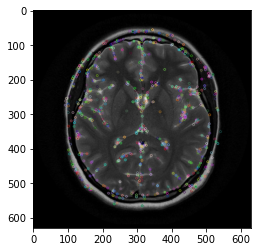

In [31]:
keypoints1, descriptor1 = sift.detectAndCompute(img1, None)
keypoints2, descriptor2 = sift.detectAndCompute(img1, None)
show_sift_features(img1, keypoints1)

In [32]:
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck = True)
matches = bf.match(descriptor1, descriptor2)

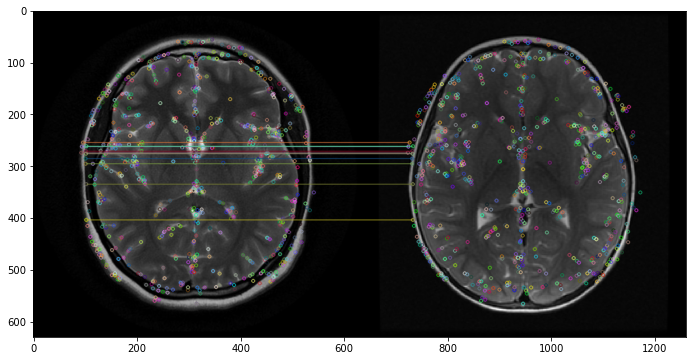

In [35]:
matches = sorted(matches, key = lambda x:x.distance)
N_MATCHES = 10

match_img = cv2.drawMatches(
    img1, keypoints1,
    img2, keypoints2,
    matches[:N_MATCHES], img1.copy(), flags=0)

plt.figure(figsize=(12,6))
plt.imshow(match_img);

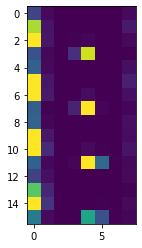

In [43]:
plt.imshow(descriptor1[0].reshape(16, 8), interpolation='none')

In [47]:
transform = [transforms.RandomRotation(90), transforms.RandomHorizontalFlip()]
train_loader = ImageDataModule(transform=transform)
trainer = pl.Trainer()
model = BaselineClf()

TypeError: 'ImageFolder' object is not an iterator